In [1]:
from utils import CustomDataset, transform, Convert_ONNX
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from resnet_model_mask import  ResidualBlock, ResNet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle

torch.manual_seed(1)
# torch.manual_seed(42)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(num_gpus)

# Create custom dataset instance
data_dir = '/mnt/buf0/pma/frbnn/train_ready'
dataset = CustomDataset(data_dir, transform=transform)
valid_data_dir = '/mnt/buf0/pma/frbnn/valid_ready'
valid_dataset = CustomDataset(valid_data_dir, transform=transform)


num_classes = 2
trainloader = DataLoader(dataset, batch_size=420, shuffle=True, num_workers=32)

model = ResNet(24, ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)
model = nn.DataParallel(model)
model = model.to(device)
params = sum(p.numel() for p in model.parameters())
print("num params ",params)


2
num params encoder  50840
num params  21496282


In [2]:
model_path = 'models/model-47-99.125.pt'

model.load_state_dict(torch.load(model_path, weights_only=True))
model = model.eval()

In [17]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60398_67123_110077819_frb20240114a_0001/LoC.C0736/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60398_67123_110077819_frb20240114a_0001/LoC.C0736/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=1859.5, nbits=8, tsamp=6.4e-05, tstart=60398.77688657407, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.915975, 4.329343)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60398_67123_110077819_frb20240114a_0001/LoC.C0736/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60398.77688657407, tsamp=6.4e-05)]))


In [45]:
int(1753.47/6.4e-05), int(1733.47/6.4e-05)

(27397968, 27085468)

  0%|                                                   | 0/382 [00:00<?, ?it/s]/tmp/ipykernel_655812/159182092.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 382/382 [00:42<00:00,  9.06it/s]


2


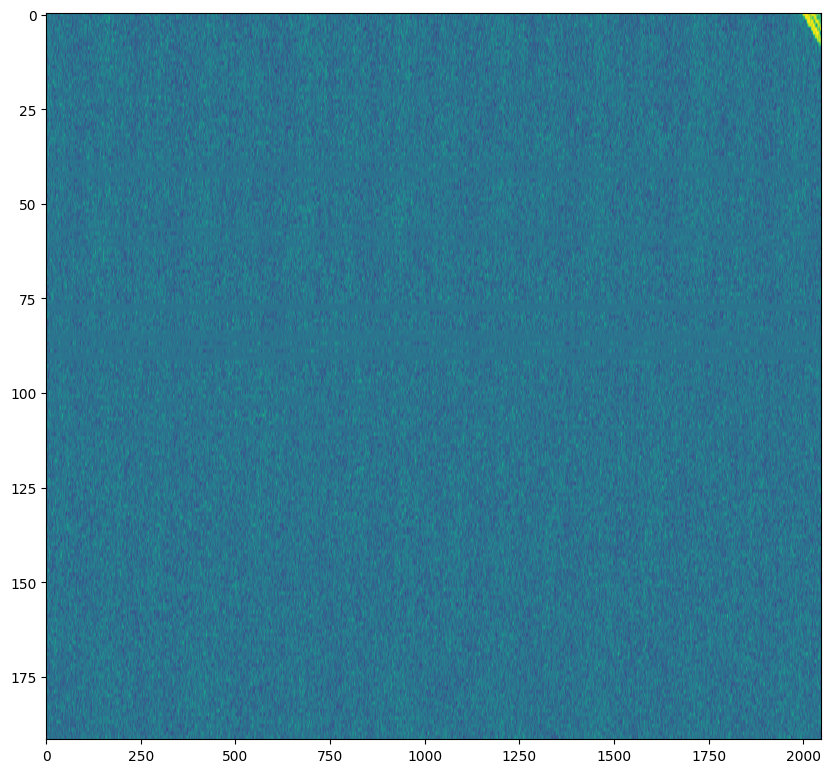

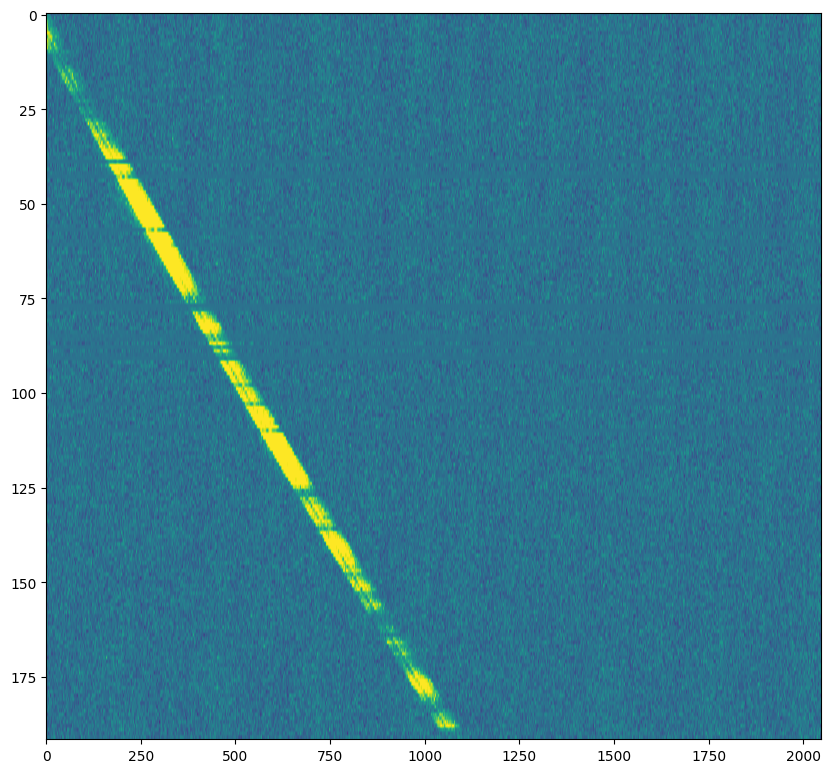

In [26]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(27085468,27397968, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9982:
        key = data.cpu().numpy()
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy(), aspect = 10 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [38]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60428_58167_24730285_frb20240114a_0001/LoC.C1504/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60428_58167_24730285_frb20240114a_0001/LoC.C1504/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=2243.5, nbits=8, tsamp=6.4e-05, tstart=60428.67322916666, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.915975, 4.329343)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60428_58167_24730285_frb20240114a_0001/LoC.C1504/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60428.67322916666, tsamp=6.4e-05)]))


In [39]:
int(521.535/6.4e-05), int(541.535/6.4e-05)

(8148984, 8461484)

  0%|                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_655812/3972874661.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 153/153 [00:28<00:00,  5.35it/s]


1


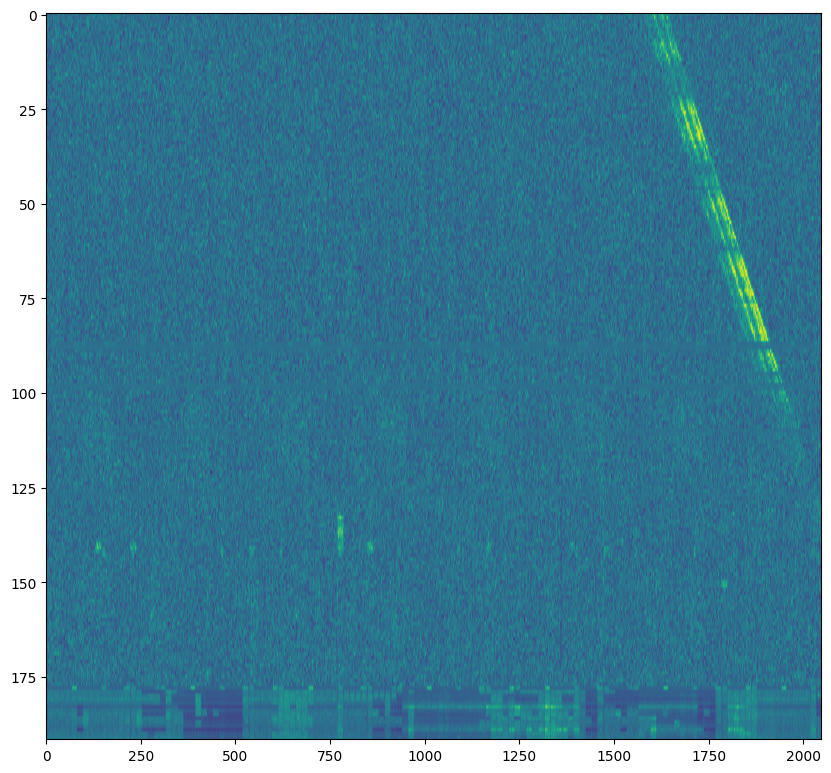

In [41]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(8148984,8461484, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9988:
        key = data.cpu().numpy()
        result = np.repeat(np.mean(data.cpu().numpy(), axis = 1)[:,None], 2048, axis=1) 
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy()/result, aspect = 10 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [42]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60427_42703_18513000_frb20240114a_0001/LoC.C1504/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60427_42703_18513000_frb20240114a_0001/LoC.C1504/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=2243.5, nbits=8, tsamp=6.4e-05, tstart=60427.49424768519, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.915975, 4.329343)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60427_42703_18513000_frb20240114a_0001/LoC.C1504/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60427.49424768519, tsamp=6.4e-05)]))


In [43]:
int(1301.96/6.4e-05), int(1321.96/6.4e-05)

(20343125, 20655625)

  0%|                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_655812/3674828792.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 153/153 [00:29<00:00,  5.11it/s]


3


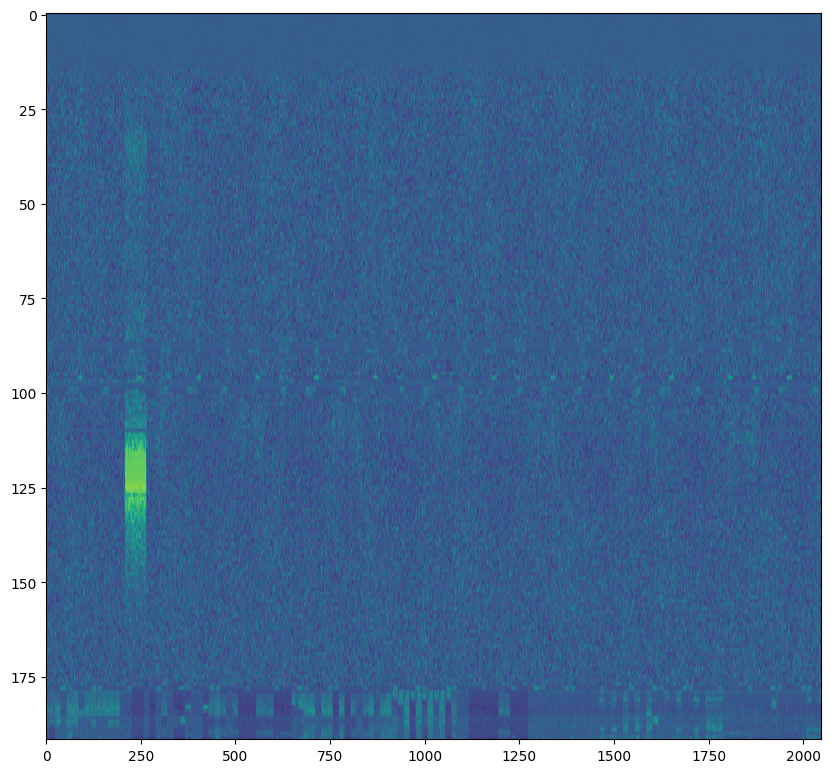

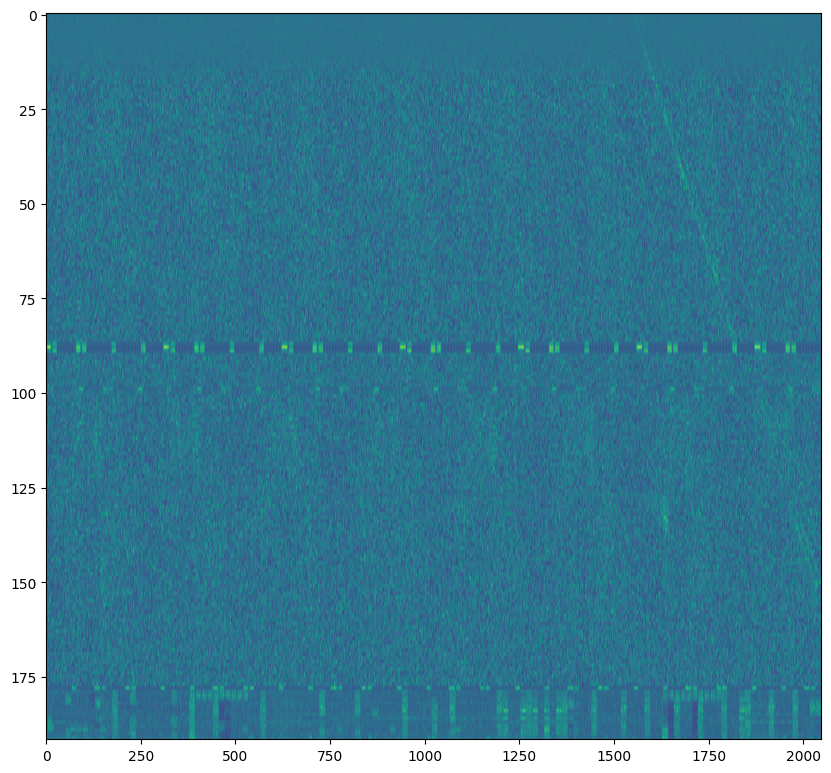

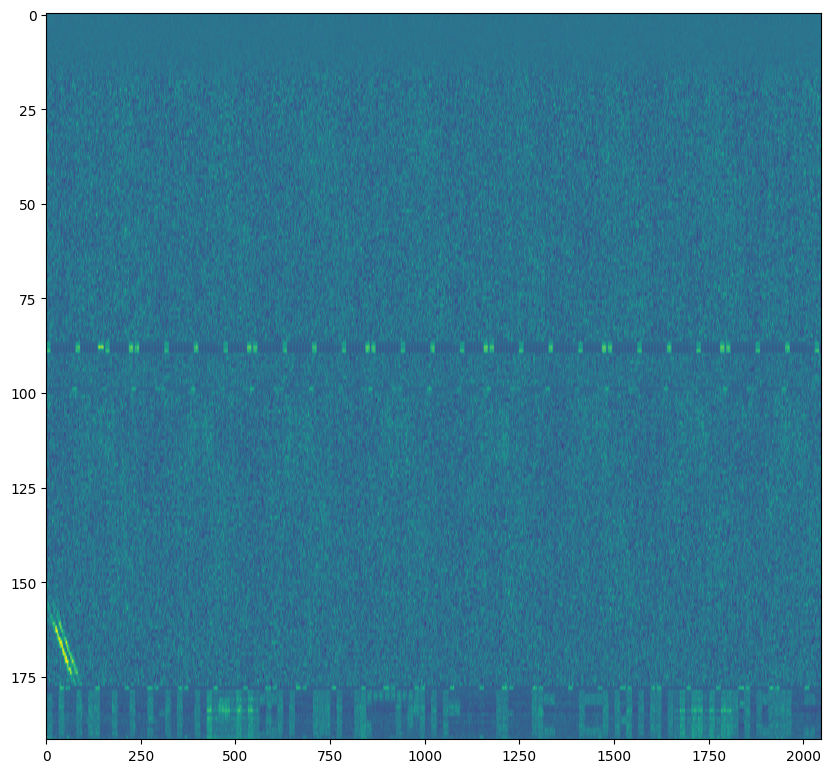

In [44]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(20343125,20655625, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9988:
        key = data.cpu().numpy()
        result = np.repeat(np.mean(data.cpu().numpy(), axis = 1)[:,None], 2048, axis=1) 
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy()/result, aspect = 10 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [54]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60395_72956_94613525_frb20240114a_0001/LoB.C1312/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60395_72956_94613525_frb20240114a_0001/LoB.C1312/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=1475.5, nbits=8, tsamp=6.4e-05, tstart=60395.84439814815, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.9162, 4.35)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60395_72956_94613525_frb20240114a_0001/LoB.C1312/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60395.84439814815, tsamp=6.4e-05)]))


In [56]:
int(557.345/6.4e-05), int(577.345/6.4e-05)

(8708515, 9021015)

  0%|                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_655812/2776917742.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 153/153 [00:29<00:00,  5.19it/s]


1


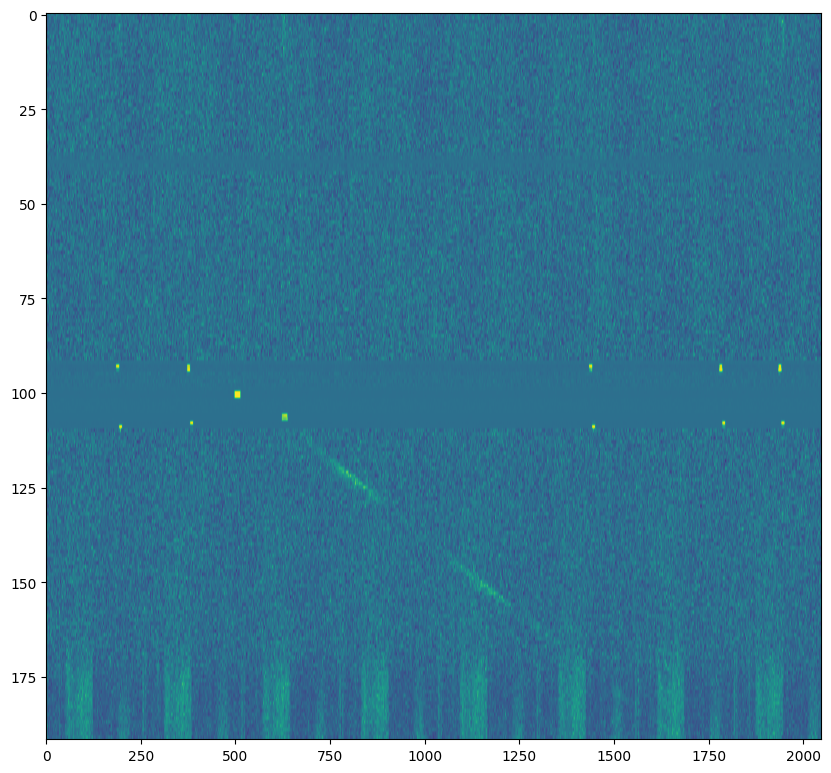

In [57]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(8708515,9021015, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9988:
        key = data.cpu().numpy()
        result = np.repeat(np.mean(data.cpu().numpy(), axis = 1)[:,None], 2048, axis=1) 
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy()/result, aspect = 10 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [63]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60429_47342_29343017_frb20240114a_0001/LoB.C1120/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60429_47342_29343017_frb20240114a_0001/LoB.C1120/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=1379.5, nbits=8, tsamp=6.4e-05, tstart=60429.547939814816, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.915975, 4.329343)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60429_47342_29343017_frb20240114a_0001/LoB.C1120/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60429.547939814816, tsamp=6.4e-05)]))


In [64]:
int(665.54/6.4e-05), int(685.54/6.4e-05)

(10399062, 10711562)

  0%|                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_655812/1194739813.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 153/153 [00:28<00:00,  5.34it/s]


2


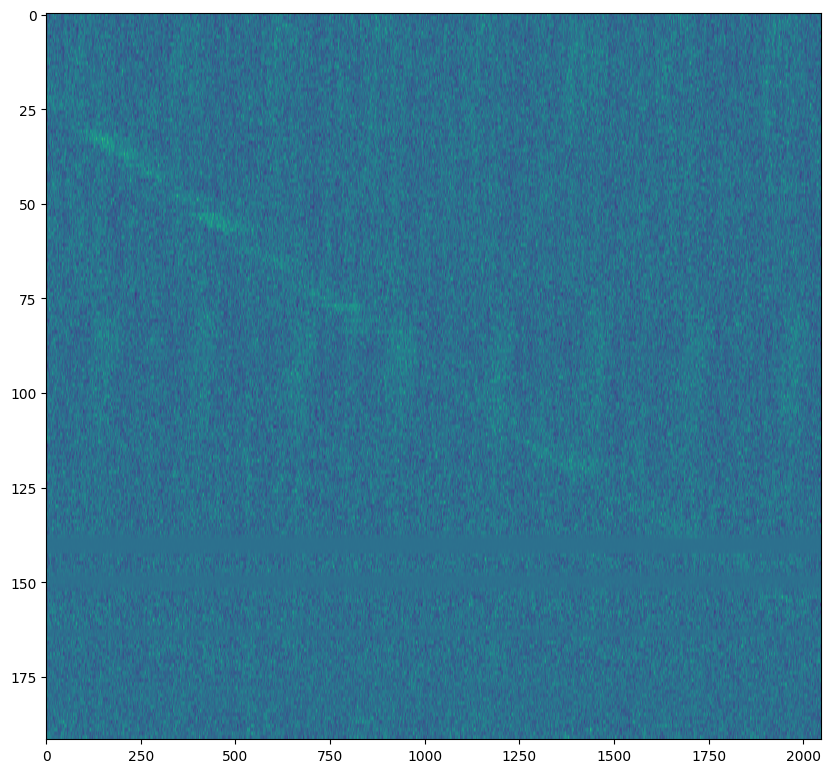

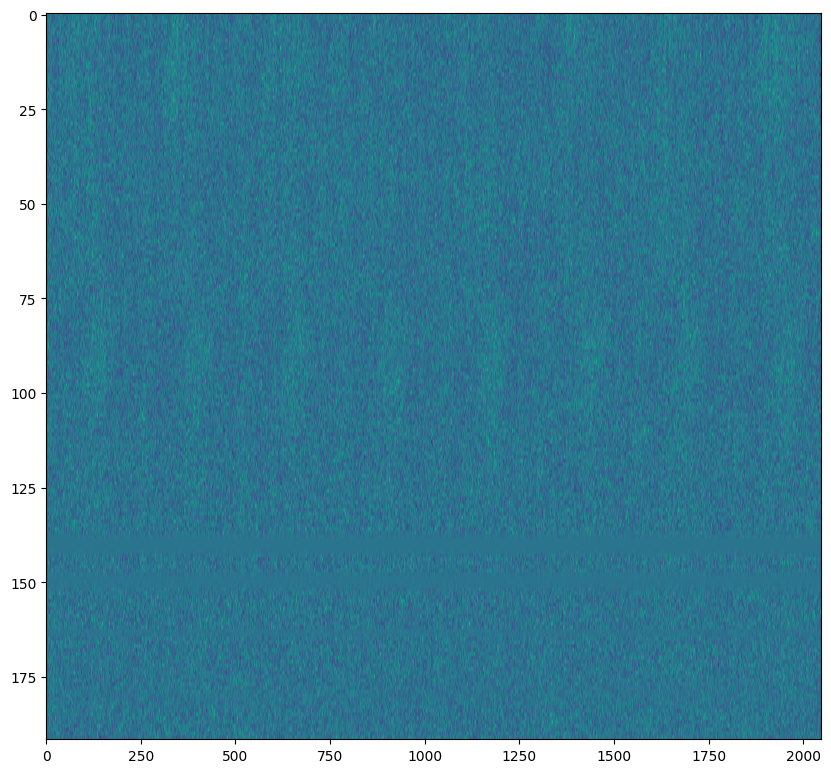

In [66]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(10399062,10711562, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9988:
        key = data.cpu().numpy()
        result = np.repeat(np.mean(data.cpu().numpy(), axis = 1)[:,None], 2048, axis=1) 
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy()/result, aspect = 10 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [71]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60456_42557_118616821_frb20240114a_0001/LoC.C1312/decimated.fil')
# fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60456_42557_118616821_frb20240114a_0001/LoC.C1312/decimated.fil', data_type='filterbank', nchans=192, foff=-0.5, fch1=2819.5, nbits=8, tsamp=6.4e-05, tstart=60456.49255787037, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (321.915975, 4.329343)>, azimuth=<Angle 0. deg>, zenith=<Angle 0. deg>, telescope='Fake', backend='FAKE', source='frb20240114a', frame='topocentric', ibeam=0, nbeams=1, dm=0, period=0, accel=0, signed=False, rawdatafile='unknown', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/results/p031/FRB20240114a_spliced/fil_60456_42557_118616821_frb20240114a_0001/LoC.C1312/decimated.fil', hdrlen=353, datalen=5400035328, nsamples=28125184, tstart=60456.49255787037, tsamp=6.4e-05)]))


In [72]:
int(80/6.4e-05), int(100/6.4e-05)

(1250000, 1562500)

  0%|                                                   | 0/153 [00:00<?, ?it/s]/tmp/ipykernel_655812/609672737.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
100%|█████████████████████████████████████████| 153/153 [00:28<00:00,  5.39it/s]


1


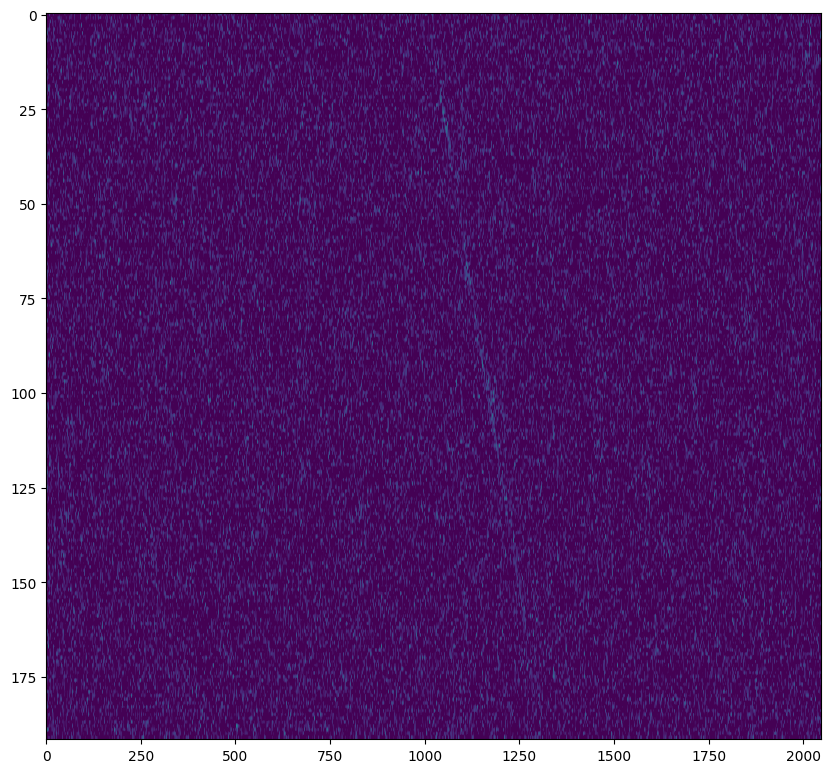

In [83]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(1250000,1562500, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if out[0, 1]>0.9988:
        key = data.cpu().numpy()
        result = np.repeat(np.mean(data.cpu().numpy(), axis = 1)[:,None], 2048, axis=1) 
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy()/result, aspect = 10,  vmin=0.99 )
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [82]:
np.median(data.cpu().numpy()/result)

0.99179804

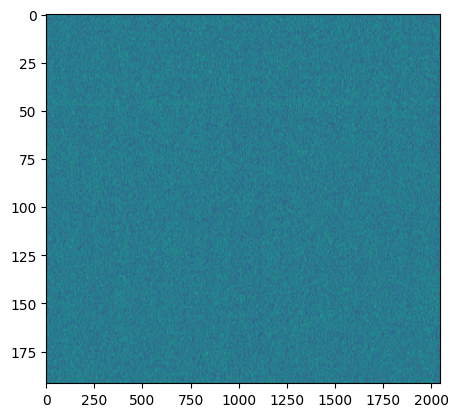

In [79]:
plt.imshow(data.cpu().numpy()/result, aspect = 10 )